<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignmnet 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [3]:
from tensorflow.keras.datasets import boston_housing

# Importing Boston Housing dataset
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(404, 13) (404,) (102, 13) (102,)


In [4]:
from sklearn.preprocessing import StandardScaler

# Normalizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Instantiate model
model = Sequential()

# Input layer
model.add(Dense(20, input_dim=13, activation='relu'))

# Hidden layer
model.add(Dense(20, activation='relu'))

# Output layer
model.add(Dense(1))

# Compile model
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                280       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = model.fit(X_train, y_train, batch_size=20, epochs=50,
                    validation_split=.1, verbose=0)

scores = model.evaluate(X_test, y_test)
print(f'{model.metrics_names[1]}: {scores[1]}')

102/102 [==============================] - 0s 25us/sample - loss: 23.2511 - mean_squared_error: 23.2511
mean_squared_error: 23.25105094909668


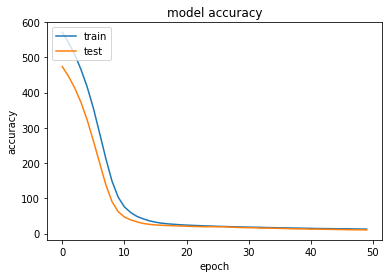

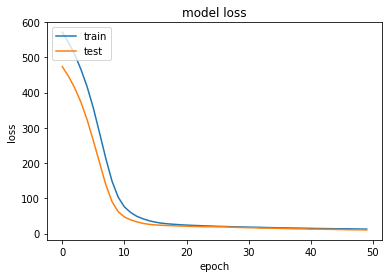

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mean_squared_error(y_test, y_pred)

23.195599256422977

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [12]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [14]:
from tensorflow.keras.utils import to_categorical

batch_size = 25
num_classes = 10
epochs = 20

X_train = X_train.reshape(60000, 784).astype('float32')
X_test = X_test.reshape(10000, 784).astype('float32')

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [15]:
# Instantiate model
model = Sequential()

# Input layer
model.add(Dense(16, input_dim=784, activation='relu'))

# Hidden layer
model.add(Dense(16, activation='relu'))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                170       
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_split=.1, verbose=0)

scores = model.evaluate(X_test, y_test)
print(f'{model.metrics_names[1]}: {scores[1]*100}')

10000/10000 [==============================] - 0s 19us/sample - loss: 0.9341 - acc: 0.6291
acc: 62.91000247001648


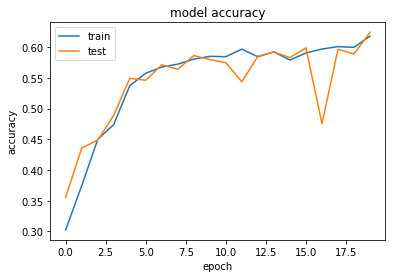

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.